## Load packages

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

## Load and show data

### Matrices


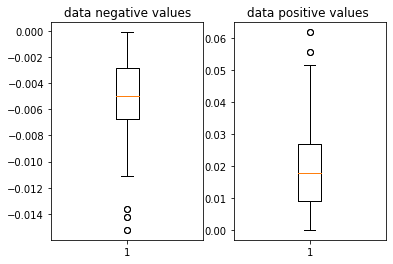

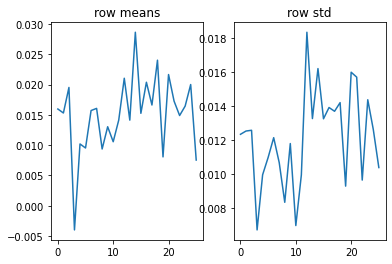

<Figure size 432x288 with 0 Axes>

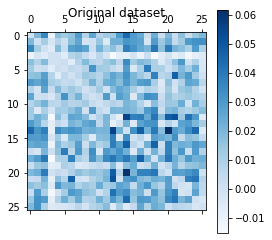

In [2]:
# Load CSV files
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

# Seeing if negative data have same order of magnitude as positive data 
def orderOfMagnitude(matrix):
    for i in range(len(matrix)):
        matrix[i,i] = 0
    
    neg = matrix[matrix<0]
    plt.subplot(121)
    plt.boxplot(neg)
    plt.title("data negative values")
    
    pos = matrix[matrix>0]
    plt.subplot(122)
    plt.boxplot(pos)
    plt.title("data positive values ")
    
# Remove outlier in array if we find one
def removeOutlierArray(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    new_mat = np.delete(new_mat, (subject), axis=1)
    
    with open(os.path.join('ISC_truncated.csv'), 'w') as File:
        writer = csv.writer(File)
        writer.writerows(matrix)
    
    return new_mat

# Remove outlier in vector if we find one
def removeOutlierVector(vector,subject):
    new_vect = np.copy(vector)
    new_vect = np.delete(new_vect, (subject), axis=0)
    return new_vect

'''
# Remove outliers everywhere
def removeOutlier(matrix,condition,subject):
    removeOutlierArray(matrix,subject)
    removeOutlierVector(condition,subject)
'''
    
# Remove Inf in data for EDA and IBI (replace by sort of normalisation for the moment
tmp = np.copy(ISC_EEG)
for i in range(len(tmp)):
    tmp[i,i] = 0
eegNorm = 3/np.mean(tmp)

for i in range(len(ISC_IBI)):
    ISC_IBI[i,i] = np.mean(ISC_IBI)*eegNorm
    ISC_EDA[i,i] = np.mean(ISC_EDA)*eegNorm
    
# Choose matrix to study
case = 'EEG'
removeOutlier = False # Remove outliers if there are some

if (case == 'EEG'):
    if (removeOutlier): # Remove outliers if there are some
        ISC_EEG = removeOutlierArray(ISC_EEG,3) # Really outlier?
    study_matrix = ISC_EEG
elif (case == 'EDA'):
    if (removeOutlier): # Remove outliers if there are some
        #ISC_EDA = removeOutlierArray(ISC_EDA,12) # Really outlier?
        #ISC_EDA = removeOutlierArray(ISC_EDA,20) # Really outlier?
        ISC_EDA = removeOutlierArray(ISC_EDA,17)
    study_matrix = ISC_EDA
elif (case == 'IBI'):
    if (removeOutlier): # Remove outliers if there are some
        print("Haven't found any outliers for the moment")
        # ISC_IBI = removeOutlierArray(ISC_IBI,)
    study_matrix = ISC_IBI

N = len(study_matrix)

# Boxplot
orderOfMagnitude(np.copy(study_matrix))

# Normalize rows and columns ?
for i in range(len(study_matrix)):
    study_matrix[i,i] = 0
    
# Remove negative values from EDA and IBI
#study_matrix = np.where(study_matrix>0,study_matrix,0)

plt.figure()
plt.subplot(121)
plt.plot(np.mean(study_matrix,axis=0))
plt.title('row means')
plt.subplot(122)
plt.plot(np.std(study_matrix,axis=0))
plt.title('row std')

# Show matrix data
plt.figure()
plt.matshow(study_matrix, cmap=plt.cm.Blues)
plt.title("Original dataset")
plt.colorbar()
plt.show()

### True groups

In [3]:
# Load true clusters
condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
if (removeOutlier): # Remove outliers if there are some
    if (case == 'EEG'):
        condition = removeOutlierVector(condition,3) # Really outlier?
    elif (case == 'EDA'):
        #condition = removeOutlierVector(condition,12) # Really outlier?
        #condition = removeOutlierVector(condition,20) # Really outlier?
        condition = removeOutlierVector(condition,17) # Really outlier?
    elif (case == 'IBI'):
        print("Haven't found any outliers for the moment")
        # condition = removeOutlierVector(condition,) # Really outlier?

narrative = np.where(condition == 0)[0]
stimulus = np.where(condition == 1)[0]

### Compute distance matrix

In [4]:
import scipy.spatial.distance as ssd

def computeDistanceMatrix(normalisation=1,uncondensed=False,euclideanTransform=False,finalNorm=False): # Choose normalisation between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1
    # Change matrix diagonal value (kind of normalisation)
    matrix_norm = np.copy(study_matrix)
    for i in range(len(matrix_norm)):
        matrix_norm[i,i] = 0
    maxi = np.max(abs(matrix_norm)) # Max value except from the diagonal

    for i in range(len(matrix_norm)):
        #matrix_norm[i,i] = maxi
        matrix_norm[i,i] = np.max(study_matrix)/normalisation

    # Normalise max value to 1
    matrix_norm = matrix_norm / np.max(abs(matrix_norm))

    # Compute distance matrix
    if (euclideanTransform):
        distance_matrix = np.sqrt(2*N*(1-matrix_norm))
    else:
        distance_matrix = 1-matrix_norm
    
    # Normalisation to avoid negative eigen values in PCoA
    distance_matrix = distance_matrix + add_coef
    for i in range(len(study_matrix)):
        distance_matrix[i,i] = 0
    
    # Transform matrix into unconsed matrix
    if (uncondensed):
        # convert the redundant n*n square matrix form into a condensed nC2 array
        distance_matrix = ssd.squareform(distance_matrix)
        
    ## Write new CSV file with all data
    if (uncondensed==False):
        with open(os.path.join('dist_'+ case + '.csv'), 'w') as File:
            writer = csv.writer(File)
            writer.writerows(distance_matrix)
            
    if (finalNorm):
        distance_matrix = distance_matrix / np.std(distance_matrix) 

    return distance_matrix
    
'''
# Normalise data
for i in range(len(matrix)):
    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])
'''

'\n# Normalise data\nfor i in range(len(matrix)):\n    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])\n'

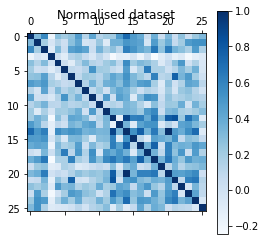

In [5]:
norm_coef = 45
add_coef = 2
distance_matrix = computeDistanceMatrix(norm_coef) # Choose between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1
study_matrix_norm = 1-(distance_matrix-add_coef)
for i in range(len(study_matrix)):
    study_matrix_norm[i,i] = 1

plt.matshow(study_matrix_norm, cmap=plt.cm.Blues)
plt.title("Normalised dataset")
plt.colorbar()
plt.show()

### Silhouette coefficient (SC)

In [6]:
from sklearn.metrics import silhouette_score

# Compute DB-score based on distance matrix(small means good clustering)
def silhouetteCoef(distance_matrix,label,metric='precomputed'):
    return silhouette_score(distance_matrix, label, metric=metric)

accuracyVect = np.array([])
SCVect = np.array([])
methodUsed = np.array([])
prior = np.array([])

## Bloc modelling / Bi-clustering

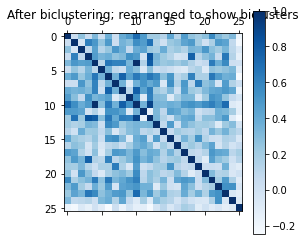

In [7]:
from sklearn.cluster import SpectralCoclustering

# Fit the model
cocluster = SpectralCoclustering(n_clusters=2, random_state=0)
cocluster.fit(study_matrix_norm)
'''
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.3f}".format(score))
'''
fit_data = study_matrix_norm[np.argsort(cocluster.row_labels_)]
fit_data = fit_data[:, np.argsort(cocluster.column_labels_)]

# Show results
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.colorbar()
plt.show()

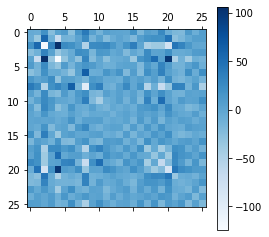

In [8]:
# Show matrix inverse (decorrelation?)
decorr = np.linalg.inv(study_matrix)

plt.matshow(decorr, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

## Defining result class

In [43]:
from sklearn.metrics import davies_bouldin_score,adjusted_rand_score

class Results():

    def __init__(self,name,random_init):
        self.accuracy = np.zeros((int(N/4)+1,len(coefficients)))
        self.best_accuracy = 0
        self.best_dim = 0
        self.best_norm = 0
        self.label = np.zeros(N)
        self.probaLabel = np.zeros(N)
        self.wellClassified = None
        self.wrongClassified = None
        self.name = name
        self.random_init = random_init
        self.best_points = np.zeros((N,2))
        self.SC = -1
        
    def thresholdLabel(self):
        self.label = np.where(self.probaLabel<0.5,0,1)
    
    def initCenters(self,NA_ref,SSA_ref,points):
        dim = points.shape[1]
        init = np.zeros((dim,2))
        init[:,0] = np.mean(points[NA_ref,:],axis=0)
        init[:,1] = np.mean(points[SSA_ref,:],axis=0)
        return init.T
        
    def twoClustersMethodResult(self):
        print("Results\n")
        if (random_init==False):
            print("Best dimension %d (7 means t-SNE)" %self.best_dim)
            print("Best normalisation %d " %self.best_norm)
        print("Found clusters ")
        print(self.label)
        print("True clusters ")
        print(condition)
        self.trueWrongClusters(self.label,condition)
        print("Well classified")
        print(self.wellClassified)
        print("Wrong classified")
        print(self.wrongClassified)
        self.best_accuracy = np.max(self.accuracy)
        print("Best %s accuracy : %f" %(self.name,self.best_accuracy))
        print("Silhouette coefficient : %0.3f" %self.SC)
        if (self.random_init):
            self.findRobustParticipants()
        
    def trueWrongClusters(self,label,condition):
        subjects = np.arange(0,N)
        self.wellClassified = subjects[label==condition]
        self.wrongClassified = subjects[label!=condition]
        
    def findRobustParticipants(self):
        robustness = 0.8
        self.robustLabel = np.where((self.probaLabel<=(1-robustness))+(self.probaLabel>=robustness),1,0)
        print("Robust participants")
        print(self.robustLabel)
        print(subjects[self.robustLabel==1])
        print("Frequencies")
        print(self.probaLabel)
        
    def applyMethod(self,method,dim=np.arange(1,int(N/4)+2)):
        print("Computing clustering\n")
        for p in range(len(coefficients)):
            print(str(int(p*100/len(coefficients))) + "%")
            distance_matrix = computeDistanceMatrix(normalisation=coefficients[p])

            for i in dim:
                if (isinstance(self,MapMethodResults)):
                    if (i<int(N/4)+1):
                        points = computePCoACoordinate(distance_matrix,n_comp=i)
                    else:
                        points = computeSNECoordinate(distance_matrix)
                    if hasattr(method, 'init'):
                        if hasattr(method.init, 'shape'):
                            method.init = self.initCenters(NA_HC,SSA_HC,points)
                    meth = method.fit(points)
                else:
                    meth = method.fit(distance_matrix)
                    
                if hasattr(meth, 'labels_'):
                    label = meth.labels_
                else:
                    label = meth.predict(points)
                
                acc = sum(condition==label)/N
                if (acc<0.5):
                    label = 1-label
                    self.accuracy[i-1,p] = 1-acc
                else:
                    self.accuracy[i-1,p] = acc
                
                if self.accuracy[i-1,p] == np.max(self.accuracy):
                    self.label = label
                    self.best_dim = i
                    self.best_norm = coefficients[p]
                    if (isinstance(self,MapMethodResults)):
                        self.best_points = points
                        self.SC = silhouetteCoef(self.best_points,self.label,metric='euclidean')
                    else:
                        self.SC = silhouetteCoef(distance_matrix,self.label,metric='precomputed')
        
    def applyMethodAverage(self,method,coef,dim=None,n_run=1):
        print("Computing clustering\n")
        distance_matrix = computeDistanceMatrix(normalisation=coef)
        for k in range(n_run):
            print(str(int(k*100/n_run)) + "%")
            if (isinstance(self,MapMethodResults)):
                if (dim<int(N/4)+1):
                    points = computePCoACoordinate(distance_matrix,n_comp=dim)
                else:
                    points = computeSNECoordinate(distance_matrix)
                if hasattr(method, 'init'):
                    if hasattr(method.init, 'shape'):
                        method.init = self.initCenters(NA_HC,SSA_HC,points)
                meth = method.fit(points)
            else:
                meth = method.fit(distance_matrix)

            if hasattr(meth, 'labels_'):
                label = meth.labels_
            else:
                label = meth.predict(points)
            label = np.array(label,dtype='float64')

            acc = sum(condition==label)/N
            if (acc<0.5):
                label = 1-label
            self.probaLabel += label/n_run
        self.thresholdLabel()
        if (isinstance(self,MapMethodResults)):
            self.best_points = points
            self.SC += silhouetteCoef(self.best_points,self.label,metric='euclidean')/n_run
        else:
            self.SC = silhouetteCoef(distance_matrix,self.label,metric='precomputed')/n_run

        acc = sum(condition==self.label)/N
        if (acc<0.5):
            self.accuracy[0,0] = 1-acc
        else:
            self.accuracy[0,0] = acc
        
    '''    
    def applyMethodAverageDist(self,method,dim=np.arange(1,int(N/4)+2),n_run=1):
        print("Computing clustering\n")
        for p in range(len(coefficients)):
            print(str(int(p*100/len(coefficients))) + "%")
            distance_matrix = computeDistanceMatrix(normalisation=coefficients[p])
            for i in dim:
                for k in range(n_run):
                    meth = method.fit(distance_matrix)
                    if hasattr(meth, 'labels_'):
                        label = meth.labels_
                    else:
                        label = meth.predict(distance_matrix)
                    label = np.array(label,dtype='float64')

                    acc = sum(condition==label)/N
                    if (acc<0.5):
                        label = 1-label
                    self.probaLabel += label/n_run
                self.thresholdLabel()
                
                self.SC = silhouetteCoef(distance_matrix,self.label,metric='precomputed')/n_run
                acc = sum(condition==self.label)/N
                if (acc<0.5):
                    self.accuracy[0,0] = 1-acc
                else:
                    self.accuracy[0,0] = acc
    '''
class DistanceMethodResults(Results):
    
    def __init__(self,name,random_init):
        Results.__init__(self,name,random_init)
        
class MapMethodResults(Results):
    
    def __init__(self,name,random_init):
        Results.__init__(self,name,random_init)
        
    def applyMethodAndMDSAverages(self,method,dim,coef,n_run=1,n_mds_run=1):
        print("Computing clustering\n")
        distance_matrix = computeDistanceMatrix(normalisation=coef)
        for i in range(n_mds_run):
            print(str(int(i*100/n_mds_run)) + "%")
            for k in range(n_run):
                if (isinstance(self,MapMethodResults)):
                    points,stress = computeMDSCoordinate(distance_matrix,dim,random_state=i)
                    meth = method.fit(points)
                else:
                    meth = method.fit(distance_matrix)

                if hasattr(meth, 'labels_'):
                    label = meth.labels_
                else:
                    label = meth.predict(points)
                label = np.array(label,dtype='float64')

                acc = sum(condition==label)/N
                if (acc<0.5):
                    label = 1-label
                self.probaLabel += label/(n_run*n_mds_run)
            self.best_points += points
        self.thresholdLabel()
        self.SC = silhouetteCoef(self.best_points,self.label,metric='euclidean')

        acc = sum(condition==self.label)/N
        if (acc<0.5):
            self.accuracy[0,0] = 1-acc
        else:
            self.accuracy[0,0] = acc
        
    def clusteringAccuracyWithDimension(self):
        # Plot clustering accuracy with increasing dimension
        for p in range(len(coefficients)):
            plt.plot(np.arange(1,int(N/4)+2),self.accuracy[:,p],label=str(coefficients[p]))
        plt.xlabel("number of mds dimensions")
        plt.ylabel("%s accuracy" %self.name)
        plt.legend()
        
    def showResultMap(self):
        plt.figure()
        
        if (self.best_dim != 1):
            ax = plt.axes([0,0,1.2,1.2])
            ax.set_aspect(aspect='equal')
            for i in range(N):
                if (i in self.wellClassified):
                    if (condition[i] == 0):
                        color = 'blue'
                        label = 'NA'
                    else:
                        color = 'red'
                        label = 'SSA'
                else:
                    color = 'black'
                    label = 'misclassified'
                ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+np.max(self.best_points)/20,self.best_points[i,1]))
                ax.scatter(self.best_points[i,0],self.best_points[i,1],color=color,s=145,label=label)
        else:
            plt.scatter(self.best_points[narrative],np.zeros((len(narrative),1)),marker='x',color='blue')
            plt.scatter(self.best_points[stimulus],np.zeros((len(stimulus),1)),marker='x',color='red')
            orderedSubjectPlot = np.argsort(self.best_points.T)
            for i in range(len(condition)):
                subj = orderedSubjectPlot[0,i]
                plt.annotate(subj,(self.best_points[subj,0],0),xytext=(self.best_points[subj,0]-((i+1)%2+1)*np.max(self.best_points)/35,0.01*(i%2)-0.0065))
    
        TP = mpatches.Patch(color='blue', label='NA')
        TN = mpatches.Patch(color='red', label='SSA')
        FP_FN = mpatches.Patch(color='black', label='misclassified')
        plt.legend(handles=[TP,TN,FP_FN])
        plt.title("%s clustering" %self.name)
        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        return davies_bouldin_score(self.best_points,self.label)

In [10]:
random_init = True # MDS with several random init
mds_random_init = True # MDS with several random init

n_run = 4 # Number of runs with different random init if random_init True
n_mds_run = 4 # Number of mds runs with different random init if mds_random_init True

## Hierarchical clustering

### Hierarchical clustering based on correlation (diagonal normalised)

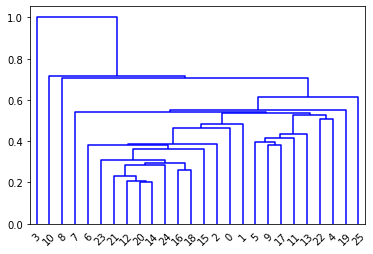

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z=linkage(study_matrix_norm,'single','correlation',optimal_ordering=True)
dendrogram(Z, color_threshold=0)
plt.show()

In [12]:
print("group 0 (NA) : ",narrative)
print("group 1 (SSA): ",stimulus)

group 0 (NA) :  [ 0  2  4  5  7  9 11 13 16 17 18 22 25]
group 1 (SSA):  [ 1  3  6  8 10 12 14 15 19 20 21 23 24]


### Hierarchical clustering based on euclidean distance

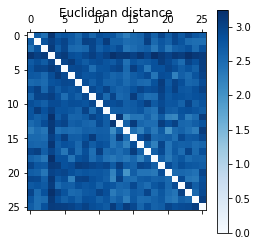

In [13]:
distance_matrix = computeDistanceMatrix(norm_coef)
plt.matshow(distance_matrix, cmap=plt.cm.Blues)
plt.title("Euclidean distance")
plt.colorbar()
plt.show()

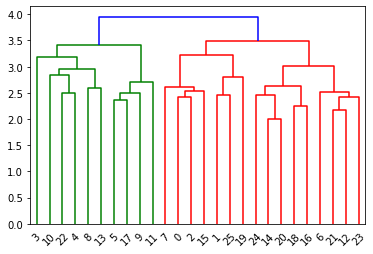

Found clusters 
[1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  4  5  6  9 11 12 13 14 15 17 19 20 21 22 23 24]
Wrong classified
[ 0  2  3  7  8 10 16 18 25]
Accuracy : 0.653846
Silhouette coefficient : 0.051


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

distance_matrix = computeDistanceMatrix(norm_coef,uncondensed=True)
Z=linkage(distance_matrix,'ward','euclidean',optimal_ordering=True)
threshold = 4-0.2*(case=='EEG') # 3.8 EEG, 4 EDA, 4 IBI if add_coef ==2
#threshold = 3.55
dendrogram(Z, color_threshold=threshold)
plt.show()

print("Found clusters ")
label = (fcluster(Z, t=threshold, criterion='distance')-1)
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_HC = subjects[label==1] # Maybe NA
NA_HC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
#[ 0  2  3  7  8 10 16 18 25]
distance_matrix = computeDistanceMatrix(norm_coef)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'HC' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'HC')
    prior = np.append(prior,'dist')

In [15]:
'''
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

distance_matrix = computeDistanceMatrix(norm_coef)
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="precomputed",linkage='single').fit(distance_matrix)
plot_dendrogram(clustering)

print("Found clusters ")
label = clustering.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_HC = subjects[label==1] # Maybe NA
NA_HC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
#[ 0  2  3  7  8 10 16 18 25]
distance_matrix = computeDistanceMatrix(norm_coef)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
'''

'\nfrom sklearn.cluster import AgglomerativeClustering\n\ndef plot_dendrogram(model, **kwargs):\n    # Create linkage matrix and then plot the dendrogram\n\n    # create the counts of samples under each node\n    counts = np.zeros(model.children_.shape[0])\n    n_samples = len(model.labels_)\n    for i, merge in enumerate(model.children_):\n        current_count = 0\n        for child_idx in merge:\n            if child_idx < n_samples:\n                current_count += 1  # leaf node\n            else:\n                current_count += counts[child_idx - n_samples]\n        counts[i] = current_count\n\n    linkage_matrix = np.column_stack([model.children_, model.distances_,\n                                      counts]).astype(float)\n    \n    # Plot the corresponding dendrogram\n    dendrogram(linkage_matrix, **kwargs)\n\ndistance_matrix = computeDistanceMatrix(norm_coef)\nclustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="precomputed",linkage=\'si

## Affinity propagation

In [16]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(affinity="precomputed").fit(distance_matrix)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)

print("Found clusters ")
label = af.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_aff = subjects[label==1] # Maybe NA
NA_aff = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
n_clusters_ = len(cluster_centers_indices)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'affinity' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'affinity')
    prior = np.append(prior,'dist')

Estimated number of clusters: 2
Found clusters 
[0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  2  5  6  8  9 10 11 13 16 17 18 19 22 25]
Wrong classified
[ 1  3  4  7 12 14 15 20 21 23 24]
Accuracy : 0.576923
Silhouette coefficient : 0.007


## K-Medoids 
robust with noisy data -> "Performance Analysis Of K-Means And K-Medoids Clustering Algorithms For A Randomly Generated Data Set"

In [17]:
from KMedoidsPaper import KMedoids

# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

kmedoids_result = DistanceMethodResults("k-medoids",random_init)
if (random_init): # Several runs with different random init
    kmedoids = KMedoids(n_clusters=2,tmax=100)
    kmedoids_result.applyMethodAverage(kmedoids,coef=norm_coef,n_run=n_run) # 2D max I think, otherwise curse of dimensionnality
else: # one run with HC results for init
    kmedoids = KMedoids(n_clusters=2,tmax=100,init=[NA_HC,SSA_HC]) # init array used before fit
    kmedoids_result.applyMethodAverage(kmedoids,coef=norm_coef) # 2D max I think, otherwise curse of dimensionnality
    
# Show results
kmedoids_result.twoClustersMethodResult()
if 'k-medoids' not in methodUsed:
    accuracyVect = np.append(accuracyVect,kmedoids_result.best_accuracy)
    SCVect = np.append(SCVect,kmedoids_result.SC)
    methodUsed = np.append(methodUsed,'k-medoids')
    prior = np.append(prior,'dist')
    #prior = np.append(prior,('t-SNE')*(spectralClustering_result.best_dim==7)+('PCoA')*(spectralClustering_result.best_dim<7))

Computing clustering

0%
25%
50%
75%
Results

Found clusters 
[0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  3  5  8  9 12 13 14 15 17 18 19 20 21]
Wrong classified
[ 2  4  6  7 10 11 16 22 23 24 25]
Best k-medoids accuracy : 0.576923
Silhouette coefficient : 0.001
Robust participants
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[ 9 17]
Frequencies
[0.25 0.5  0.5  0.75 0.5  0.25 0.25 0.5  0.5  0.   0.25 0.5  0.5  0.25
 0.75 0.75 0.5  0.   0.25 0.5  0.5  0.75 0.5  0.25 0.25 0.5 ]


## Spectral clustering (precomputed -> distance matrix)

In [18]:
'''
from sklearn.cluster import SpectralClustering

distance_matrix = computeDistanceMatrix(norm_coef)
clustering = SpectralClustering(n_clusters=2, n_init=1000,affinity='precomputed').fit(distance_matrix)
print("Found clusters ")
label = clustering.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_SC = subjects[label==1] # Maybe NA
NA_SC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'SC_dist' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'SC_dist')
    prior = np.append(prior,'dist')
''' 
    
    
    
from sklearn.cluster import SpectralClustering

# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

clusteringDist_result = DistanceMethodResults("spectral clustering based on distances",random_init)
if (random_init): # Several runs with different random init
    clusteringDist = SpectralClustering(n_clusters=2, n_init=100,affinity='precomputed')
    clusteringDist_result.applyMethodAverage(clusteringDist,coef=norm_coef,n_run=n_run) # 2D max I think, otherwise curse of dimensionnality
    
    # Show results
    clusteringDist_result.twoClustersMethodResult()
    if 'SC_dist' not in methodUsed:
        accuracyVect = np.append(accuracyVect,clusteringDist_result.best_accuracy)
        SCVect = np.append(SCVect,clusteringDist_result.SC)
        methodUsed = np.append(methodUsed,'SC_dist')
        prior = np.append(prior,'dist')

Computing clustering

0%
25%
50%
75%
Results

Found clusters 
[1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  2  3  4  5  7  8  9 10 13 14 21 23 25]
Wrong classified
[ 0  6 11 12 15 16 17 18 19 20 22 24]
Best spectral clustering based on distances accuracy : 0.538462
Silhouette coefficient : -0.008
Robust participants
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Frequencies
[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0.]


## Multi Dimensionnal Scaling

### Modified scikit MDS (because there is no normalised stress)

In [19]:
from MDS_normalized import MDS as MDS_norm
from sklearn import preprocessing

# MDS with normalised stress
def computeMDSCoordinate(distance_matrix,n_comp,metric=True,printStress=False,dissimilarity='precomputed',random_state=None):
    mds = MDS_norm(n_components=n_comp,random_state=random_state,normalize=True,eps=1e-10,metric=metric,dissimilarity=dissimilarity)
    mds.fit(distance_matrix)
    points = mds.embedding_
    stress = mds.stress_
    '''
    Stress-1 that according to Kruskal (1964, p. 3) has more or less 
    the following interpretation: value 0 indicates perfect fit, 
    0.025 excellent, 0.05 good, 0.1 fair and 0.2 poor.
    '''
    if (printStress):
        print("Stress of the method : %f" %stress)
    points = preprocessing.scale(points)
    return points, stress

//anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Scikit MDS

In [20]:
# Scikit MDS
from sklearn.manifold import MDS

def mdsScikit(n_comp,distance_matrix,dissimilarity='precomputed'):
    mds = MDS(n_components=n_comp,random_state=1,dissimilarity=dissimilarity,eps=1e-10)
    mds.fit(distance_matrix)
    points = mds.embedding_
    stress = mds.stress_

    '''
    # Normalise data
    for i in range(n_comp):
        points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])
    '''
    points = preprocessing.scale(points)
    return points

### Show MDS results

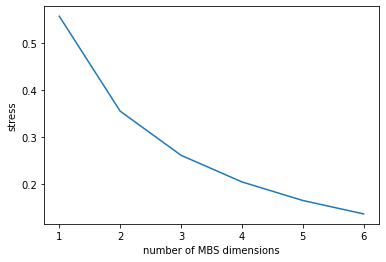

In [52]:
from sklearn.decomposition import PCA

# Make PCA to project MDS data in 2D
def transformPoints(points,n_comp=2):
    if ((points.shape[1] != 2) or (n_comp!=2)):
        # Normalise data
        for i in range(len(points[1,:])):
            points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])

        pca = PCA(n_components=n_comp)
        points = pca.fit_transform(points)
        print("%f variance explained when plotting" %sum(pca.explained_variance_ratio_[:n_comp]))
    return points

# Show MDS scaling
import matplotlib.patches as mpatches

def plotPoints(points,projection=False,title='Ground truth'):
    if (points.shape[1] != 1):
        ax = plt.axes([1.2,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        if (projection):
            points = transformPoints(points)

        for i in range(len(condition)):
            ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))

        plt.scatter(points[narrative,0],points[narrative,1],color='blue',s=145,label='NA')
        plt.scatter(points[stimulus,0],points[stimulus,1],color='red',s=145,label='SSA')
    else:
        plt.scatter(points[narrative],np.zeros((len(narrative),1)),marker='x',color='blue')
        plt.scatter(points[stimulus],np.zeros((len(stimulus),1)),marker='x',color='red')
        orderedSubjectPlot = np.argsort(points.T)
        for i in range(len(condition)):
            subj = orderedSubjectPlot[0,i]
            plt.annotate(subj,(points[subj,0],0),xytext=(points[subj,0]-((i+1)%2+1)*np.max(points)/35,0.01*(i%2)-0.0065))
        
    NA = mpatches.Patch(color='blue', label='NA')
    SSA = mpatches.Patch(color='red', label='SSA')
    plt.legend(handles=[NA,SSA])
    
    plt.title(title)

# Find best MDS dimension
stress = np.zeros((int(N/4),1)) # dimension rule : dimension < N/4 
distance_matrix = computeDistanceMatrix(norm_coef)
for i in range(1,int(N/4)+1):
    points,stress[i-1] = computeMDSCoordinate(distance_matrix,i,random_state=1)

plt.plot(np.arange(1,int(N/4)+1),stress)
plt.xlabel("number of MBS dimensions")
plt.ylabel("stress")

# EEG : 6
# EDA : 3 or 4
mdsDim = 6


0.356245 variance explained when plotting
Stress of the method : 0.136892
0.356245 variance explained when plotting


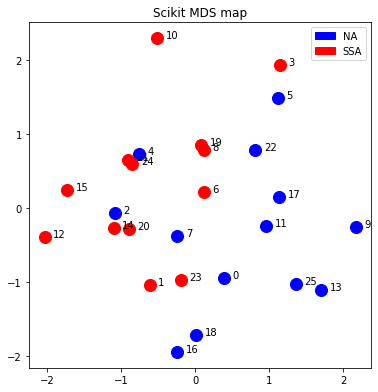

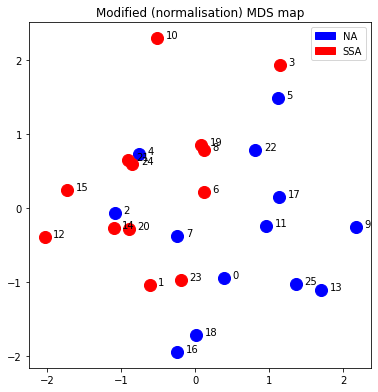

In [47]:
# MDS with Normalised stress
points = mdsScikit(mdsDim,distance_matrix,dissimilarity='precomputed')
plotPoints(points,projection=True,title='Scikit MDS map')
plt.figure()
points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True,random_state=1)
plotPoints(points,projection=True,title='Modified (normalisation) MDS map')

## Deterministic PCoA

pcoa proportion explained : 0.18069308323003502 


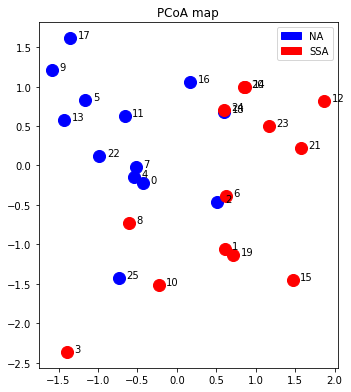

In [23]:
from skbio.stats.ordination import pcoa

def computePCoACoordinate(distance_matrix,n_comp=2):
    
    pcoa_map = pcoa(distance_matrix, method='eigh', number_of_dimensions=n_comp)
    #print(pcoa_map.proportion_explained)
    print("pcoa proportion explained : %s " %np.sum(pcoa_map.proportion_explained))
    #print("eigen values")
    #print(pcoa_map.eigvals)
    points = np.array(pcoa_map.samples)
    points = preprocessing.scale(points)
    return points

distance_matrix = computeDistanceMatrix(norm_coef)
points = computePCoACoordinate(distance_matrix,2)
points = transformPoints(points)
plotPoints(points,title='PCoA map')

## t-SNE

pcoa proportion explained : 0.18069308323003502 


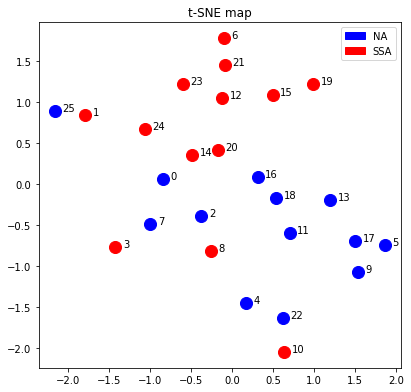

In [24]:
from sklearn.manifold import TSNE

def computeSNECoordinate(distance_matrix,n_pcoa_comp=2,n_tsne_comp=2):
    #points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True)
    pcoa_points = computePCoACoordinate(distance_matrix,n_pcoa_comp)
    points_lessD = transformPoints(pcoa_points,n_tsne_comp)
    tsne = TSNE(n_components=n_tsne_comp, perplexity=4, n_iter=3000,metric="precomputed", init=points_lessD)
    tsne_points = tsne.fit_transform(distance_matrix)
    #tsne_points = transformPoints(tsne_points)
    tsne_points = preprocessing.scale(tsne_points)
    return tsne_points
    
distance_matrix = computeDistanceMatrix(norm_coef)
points = computeSNECoordinate(distance_matrix)
plotPoints(points,title='t-SNE map')

## LDA

pcoa proportion explained : 0.3900663495885609 
pcoa proportion explained : 0.3900663495885609 
0.200000 variance explained when plotting


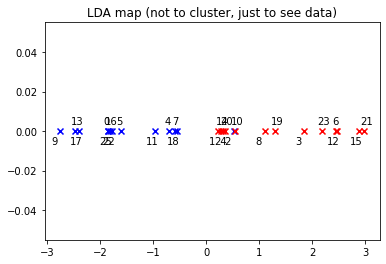

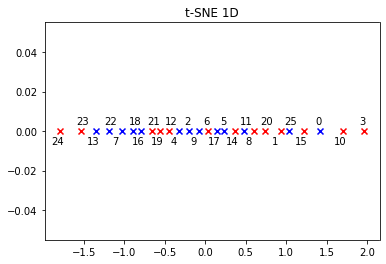

In [25]:
def plot1D(points,title):
    plt.scatter(points[narrative],np.zeros((len(narrative),1)),marker='x',color='blue')
    plt.scatter(points[stimulus],np.zeros((len(stimulus),1)),marker='x',color='red')
    orderedSubjectPlot = np.argsort(points.T)
    for i in range(len(condition)):
        subj = orderedSubjectPlot[0,i]
        plt.annotate(subj,(points[subj,0],0),xytext=(points[subj,0]-((i+1)%2+1)*np.max(points)/35,0.01*(i%2)-0.0065))
    plt.title(title)
    
# Load libraries
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

dim = 5
distance_matrix = computeDistanceMatrix(norm_coef)
points = computePCoACoordinate(distance_matrix,dim)
lda = LinearDiscriminantAnalysis(n_components=1)
points = lda.fit(points, condition).transform(points)
plot1D(points,'LDA map (not to cluster, just to see data)')

plt.figure()
distance_matrix = computeDistanceMatrix(norm_coef)
points = computeSNECoordinate(distance_matrix,dim,1)
plot1D(points,'t-SNE 1D')

## DBSCAN (here with option "precomputed metric" -> array of distances)

In [26]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
distance_matrix = computeDistanceMatrix()
db = DBSCAN(eps=1, min_samples=1,metric='precomputed').fit(distance_matrix)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 26


pcoa proportion explained : 0.18069308323003502 
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot


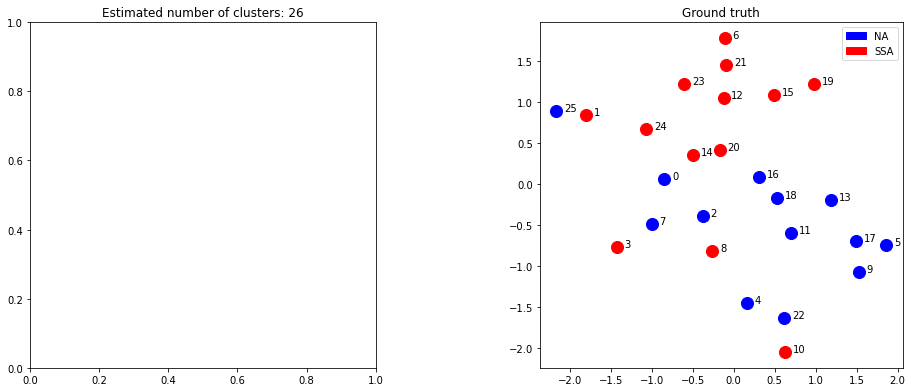

In [27]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
distance_matrix = computeDistanceMatrix()
#points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed')
#points_lessD = transformPoints(points)
points = computeSNECoordinate(distance_matrix)

for k, col in zip(unique_labels, colors):

    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = points[class_member_mask & core_samples_mask]
    try:
        plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
    except:
        print("no plot")
    xy = points[class_member_mask & ~core_samples_mask]
    try:
        plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    except:
        print("no plot")
        
plt.title('Estimated number of clusters: %d' % n_clusters_)

# Compare to ground truth
plotPoints(points,projection=True)

## Mean Shift (to do on coordinates)

pcoa proportion explained : 0.18069308323003502 
number of estimated clusters : 2


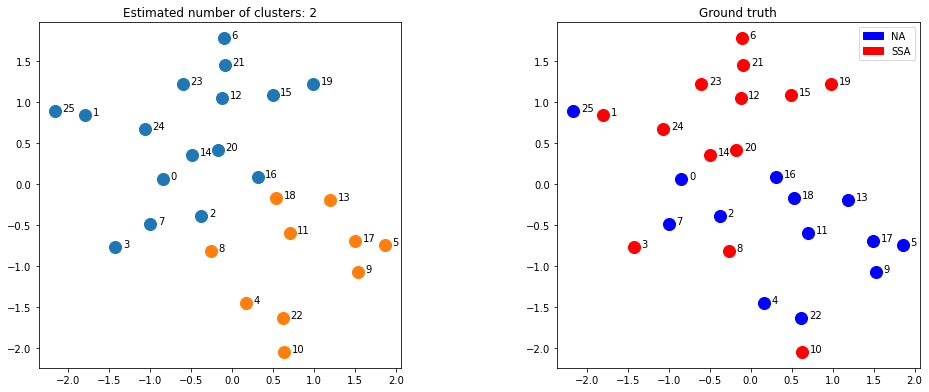

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Compute clustering with MeanShift
distance_matrix = computeDistanceMatrix(norm_coef)
points = computeSNECoordinate(distance_matrix)

# Compare to ground truth
plotPoints(points,projection=True)

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(points, quantile=0.35) # 0.35 : heuristically found to have 2 clusters

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result
from itertools import cycle

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
#points = transformPoints(points)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    ax.scatter(points[my_members, 0], points[my_members, 1], s=145)
    
    subjects = np.arange(0,N)
    for i in subjects[my_members==1]:
        ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)

## 2-cluster methods

### K-Means

In [44]:
from sklearn.cluster import KMeans
random_init = False
mds_random_init = False

# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

kmeans_result = MapMethodResults("k-means",random_init)
if (random_init): # Make several runs
    if (mds_random_init): # MDS  
        kmeans = KMeans(n_clusters=2,n_init=1)
        kmeans_result.applyMethodAndMDSAverages(kmeans,dim=2,coef=norm_coef,n_run=n_run,n_mds_run=n_mds_run) # 2D max I think, otherwise curse of dimensionnality
    else:
        kmeans = KMeans(n_clusters=2,n_init=1)
        kmeans_result.applyMethodAverage(kmeans,dim=2,coef=norm_coef,n_run=n_run) # 2D max I think, otherwise curse of dimensionnality
else: # Compare effect of normalization and dimension
    # kmeans = KMeans(n_clusters=2,n_init=1) # init array used before fit
    kmeans = KMeans(n_clusters=2,n_init=100)
    kmeans_result.applyMethod(kmeans,dim=[1,2,7]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%
pcoa proportion explained : 0.09891523543950698 
pcoa proportion explained : 0.18069308323003502 
pcoa proportion explained : 0.18069308323003502 


Results

Best dimension 1 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  4  5  6  7  9 11 12 13 14 15 17 19 20 21 22 23 24 25]
Wrong classified
[ 2  3  8 10 16 18]
Best k-means accuracy : 0.769231
Silhouette coefficient : 0.687
DB index : 0.433431 


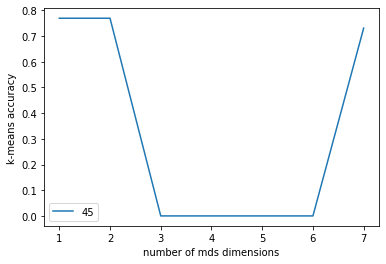

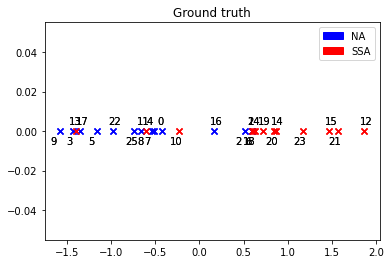

In [53]:
# Show results
kmeans_result.clusteringAccuracyWithDimension()
kmeans_result.twoClustersMethodResult()
kmeans_result.showResultMap()
plotPoints(kmeans_result.best_points)
#plt.scatter(kmeans.init[:,0],kmeans.init[:,1],s=200,marker='x') # if t-SNE and 1 coef
print("DB index : %f " %kmeans_result.dbScore())
if 'k-means' not in methodUsed:
    accuracyVect = np.append(accuracyVect,kmeans_result.best_accuracy)
    SCVect = np.append(SCVect,kmeans_result.SC)
    methodUsed = np.append(methodUsed,'k-means')
    prior = np.append(prior,('t-SNE')*(kmeans_result.best_dim==7)+('PCoA')*(kmeans_result.best_dim<7))

### Spectral Clustering

In [34]:
from sklearn.cluster import SpectralClustering

# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

spectralClustering_result = MapMethodResults("spectral clustering",random_init)

if (random_init): # Make several runs
    if (mds_random_init): # MDS        
        spectralClustering = SpectralClustering(n_clusters=2,n_init=1)
        spectralClustering_result.applyMethodAndMDSAverages(spectralClustering,dim=2,coef=norm_coef,n_run=n_run,n_mds_run=n_mds_run) # 2D max I think, otherwise curse of dimensionnality
    else: # PCoA or t-SNE
        spectralClustering = SpectralClustering(n_clusters=2,n_init=1)
        spectralClustering_result.applyMethodAverage(spectralClustering,dim=2,coef=norm_coef,n_run=n_run) # 2D max I think, otherwise curse of dimensionnality
else: # Compare effect of normalization and dimension
    spectralClustering = SpectralClustering(n_clusters=2, n_init=1000)
    spectralClustering_result.applyMethod(spectralClustering,dim=[1,2,7]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%
25%
50%
75%


Results

Found clusters 
[0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  3  4  5  6  9 11 12 13 14 15 16 17 19 20 21 22 23 24]
Wrong classified
[ 2  7  8 10 18 25]
Best spectral clustering accuracy : 0.769231
Silhouette coefficient : 0.347
Robust participants
[0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
[ 1  2  4  6  8  9 11 12 13 14 15 17 18 19 20 21 22 23 24]
Frequencies
[0.25   1.     1.     0.5625 0.     0.25   1.     0.625  0.     0.
 0.25   0.     1.     0.     0.875  1.     0.25   0.     0.9375 1.
 0.875  1.     0.     1.     0.875  0.625 ]
DB index : 1.016077 


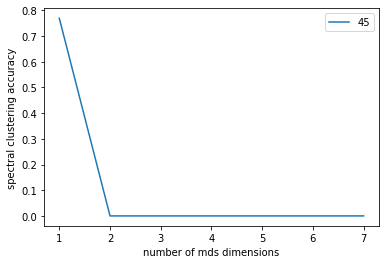

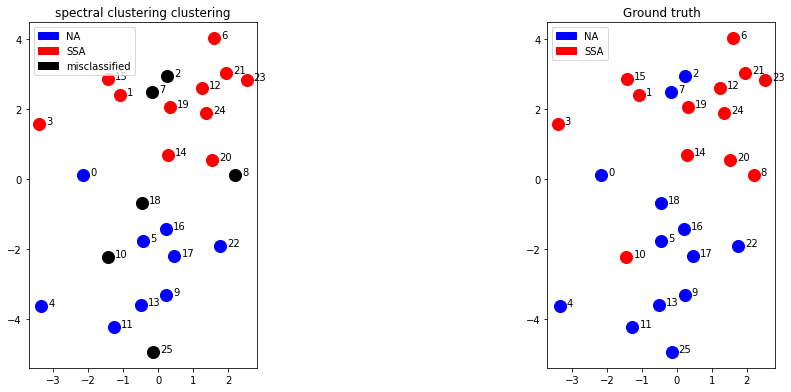

In [35]:
# Show results
spectralClustering_result.clusteringAccuracyWithDimension()
spectralClustering_result.twoClustersMethodResult()
spectralClustering_result.showResultMap()
plotPoints(spectralClustering_result.best_points)
print("DB index : %f " %spectralClustering_result.dbScore())
if 'SC_map' not in methodUsed:
    accuracyVect = np.append(accuracyVect,spectralClustering_result.best_accuracy)
    SCVect = np.append(SCVect,spectralClustering_result.SC)
    methodUsed = np.append(methodUsed,'SC_map')
    prior = np.append(prior,('t-SNE')*(spectralClustering_result.best_dim==7)+('PCoA')*(spectralClustering_result.best_dim<7))

### GMM

In [36]:
from sklearn.mixture import GaussianMixture

# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

gmm_result = MapMethodResults("gaussian mixture",random_init)
if (random_init): # Make several runs
    if (mds_random_init): # MDS  
        gmm = GaussianMixture(n_components=2,n_init=1)
        gmm_result.applyMethodAndMDSAverages(gmm,dim=2,coef=norm_coef,n_run=n_run,n_mds_run=n_mds_run) # 2D max I think, otherwise curse of dimensionnality
    else:
        gmm = GaussianMixture(n_components=2,n_init=1)
        gmm_result.applyMethodAverage(gmm,dim=2,coef=norm_coef,n_run=n_run) # 2D max I think, otherwise curse of dimensionnality
else: # Compare effect of normalization and dimension
    gmm = GaussianMixture(n_components=2, n_init=1000)
    gmm_result.applyMethod(gmm,dim=[1,2,7]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%
25%
50%
75%


Results

Found clusters 
[0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  4  5  6  9 11 12 13 14 15 16 17 19 20 21 22 23 24 25]
Wrong classified
[ 2  3  7  8 10 18]
Best gaussian mixture accuracy : 0.769231
Silhouette coefficient : 0.413
Robust participants
[0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0]
[ 4  5  6  9 11 12 13 15 17 19 21 22 23]
Frequencies
[0.4375 0.75   0.75   0.4375 0.1875 0.1875 0.9375 0.625  0.4375 0.
 0.375  0.1875 0.875  0.     0.5    0.875  0.3125 0.0625 0.5    0.875
 0.6875 0.8125 0.125  0.875  0.6875 0.375 ]
DB index : 0.828274 


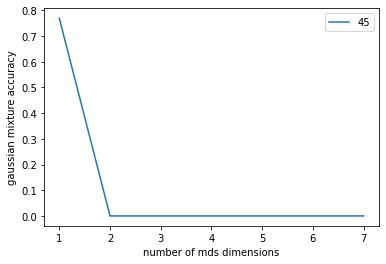

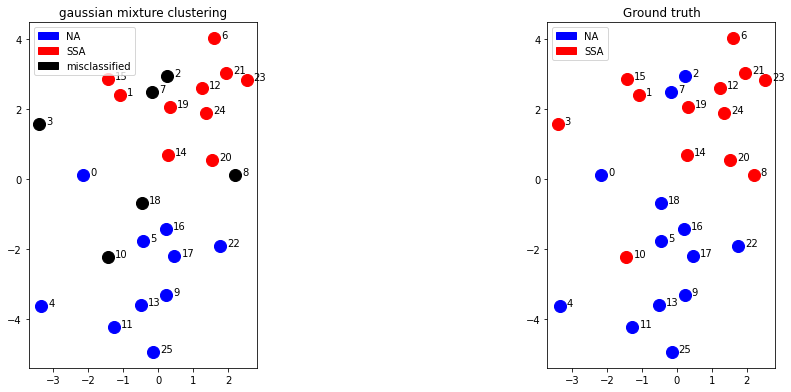

In [37]:
# Show results
gmm_result.clusteringAccuracyWithDimension()
gmm_result.twoClustersMethodResult()
gmm_result.showResultMap()
plotPoints(gmm_result.best_points)
print("DB index : %f " %gmm_result.dbScore())
if 'GMM' not in methodUsed:
    accuracyVect = np.append(accuracyVect,gmm_result.best_accuracy)
    SCVect = np.append(SCVect,gmm_result.SC)
    methodUsed = np.append(methodUsed,'GMM')
    prior = np.append(prior,('t-SNE')*(gmm_result.best_dim==7)+('PCoA')*(gmm_result.best_dim<7))    

## Comparing accuracy and silhouette coefficient

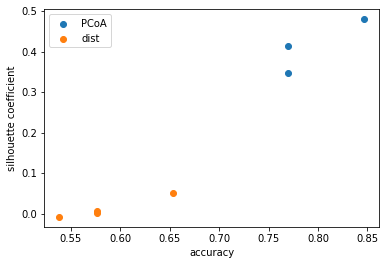

In [38]:
for meth in np.unique(prior):
    plt.scatter(accuracyVect[prior==meth],SCVect[prior==meth],label=meth) # Hard to compare MDS results because of random init

plt.xlabel("accuracy")
plt.ylabel("silhouette coefficient")
plt.legend()
plt.show()